In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData
import anndata as ad
import matplotlib.pyplot as plt

result_dir = "../edges/"
raw_type=False
use_edge=False
normalize=True

In [2]:
import matplotlib.pyplot as plt
# Set global font sizes using rcParams
plt.rcParams.update({
    'font.size': 18,            # Global font size
    'axes.titlesize': 20,       # Font size of the axes title
    'axes.labelsize': 20,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x-tick labels
    'ytick.labelsize': 16,      # Font size of the y-tick labels
    'legend.fontsize': 18,      # Font size of the legend
    'figure.titlesize': 24      # Font size of the figure title
})

In [3]:
sample='mouse1_slice201'#.pth
data_dir = "../../data/Mouse_brain/processed1/"
str_position_x='centerx'
str_position_y='centery'
str_cell_type='subclass'

In [4]:
genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
print(genes)
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

cell_types=['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT',
                    'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg',
                    'Sst', 'VLMC', 'Vip', 'other']

cell_type_pair_sequence=[]
for cell_typei in cell_types:
    for cell_typej in cell_types:
        cell_type_pair_sequence.append(cell_typei+"->"+cell_typej)

feature_names=[]
for i in range(len(cell_types)):
    for j in range(len(genes)):
        feature_names.append(cell_types[i]+"--"+genes[j])

['1700022I11Rik', '1810046K07Rik', '5031425F14Rik', '5730522E02Rik', 'Acta2', 'Adam2', 'Adamts2', 'Adamts4', 'Adra1b', 'Alk', 'Ankfn1', 'Ano4', 'Aqp4', 'Asic4', 'B4galnt2', 'B4galnt3', 'Barx2', 'Bcl11b', 'Bdnf', 'Bgn', 'Blnk', 'Bmpr1b', 'Brinp3', 'C1ql3', 'C1qtnf7', 'Cacng5', 'Calb2', 'Camk2d', 'Car3', 'Cbln2', 'Cbln4', 'Ccbe1', 'Ccdc162', 'Ccdc3', 'Ccdc80', 'Ccnb1', 'Cd14', 'Cd24a', 'Cdca7', 'Cdcp1', 'Cdh12', 'Cdh13', 'Cdh20', 'Cdh9', 'Ceacam9', 'Cemip', 'Chat', 'Chn2', 'Chodl', 'Chrm2', 'Chrna2', 'Cldn5', 'Clrn1', 'Cntnap5b', 'Cobll1', 'Col14a1', 'Col15a1', 'Col23a1', 'Col24a1', 'Col25a1', 'Corin', 'Cplx3', 'Crhr2', 'Crispld2', 'Cspg4', 'Ctss', 'Cux2', 'Cxcl14', 'Daam2', 'Dmkn', 'Dnase1l3', 'Dscaml1', 'Egfem1', 'Egfr', 'Egln3', 'Egr2', 'Elfn1', 'Enpp6', 'Epha7', 'Fam19a2', 'Fam84b', 'Fbxl7', 'Fezf2', 'Flrt3', 'Flt1', 'Fndc7', 'Fosb', 'Foxp2', 'Frem2', 'Fst', 'Gfap', 'Glra1', 'Gpc6', 'Grik1', 'Grin3a', 'Grm1', 'Grm8', 'Hpse', 'Hs3st5', 'Igf2', 'Igfbp4', 'Igfbp5', 'Ikzf2', 'Il1rapl2', 

In [5]:
import pandas as pd
def load_sample_position(sample,add_column=True):
    df = pd.read_csv(data_dir+sample+".csv")
    # Step 1: Create a new column based on conditions
    df['cell_type_plot'] = df[str_cell_type].apply(lambda x: x.split(" ")[0] if x.startswith('L') else "Other_not_excitatory_neuron")

    adata_position=AnnData(np.zeros((df.shape[0],len(genes))))
    adata_position.obs['cell_type'] = df[str_cell_type].values
    adata_position.obs["cell_type_plot"]=df['cell_type_plot'].values
    adata_position.obs["group"]=df['cell_type_plot'].values
    adata_position.obs['to_position_x']=df[str_position_x].values
    adata_position.obs['to_position_y']=df[str_position_y].values
    adata_position.obs['from_position_x']=df[str_position_x].values
    adata_position.obs['from_position_y']=df[str_position_y].values
    return df,adata_position

df_position,adata_position=load_sample_position(sample)

In [6]:
def aggregate_interation_strength(sample,select_hvg=False,normalize=True):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))

    position_x=results["position_x"][:,0]
    position_y=results["position_y"][:,0]
    cell_type_name=np.array(results["cell_type_name"])
    cell_type_target=cell_type_name[:,0]

    type_exps=torch.stack([torch.Tensor(type_exp_dict[cell_type_targeti]) for cell_type_targeti in cell_type_target],dim=0)
    results["y"]=results["y"]+type_exps
    
    attention_scores=results["attention_score"]
    cell_type_names = np.array(results["cell_type_name"])

    proportion=torch.abs(attention_scores)
    proportion=proportion/torch.sum(proportion,dim=1,keepdim=True)
    attention_scores[proportion<0.025]=0
    
    # Initialize a tensor to hold aggregated interaction strengths
    B, _, C = attention_scores.shape
    t = len(cell_types)
    aggregated_interactions = torch.zeros((B, t, C))
    
    # Map cell type names to indices
    cell_type_to_index = {ct: idx for idx, ct in enumerate(cell_types)}
    
    # Aggregate interaction strengths by cell type
    for b in range(B):
        for n in range(1, 50):  # Skip the first element, which is the target cell type
            neighbor_type = cell_type_names[b][n]
            if neighbor_type in cell_type_to_index:
                idx = cell_type_to_index[neighbor_type]
                aggregated_interactions[b, idx] += attention_scores[b, n-1]
 
    if normalize:
        aggregated_interactions=torch.abs(aggregated_interactions)/torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)
    
    #aggregated_interactions=torch.abs(aggregated_interactions)
    #aggregated_interactions=aggregated_interactions/torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)
    #aggregated_interactions[torch.abs(aggregated_interactions)<0.025]=0

    adata = AnnData(aggregated_interactions.reshape(B,-1).numpy())
    adata.obs['cell_type'] = cell_type_target
    adata.obs['Spatial x']=position_x
    adata.obs['Spatial y']=position_y
    adata.var_names=feature_names
    adata.obsm["y"]=results["y"].numpy()

    # Quality control
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    if select_hvg:
        # Identify highly variable genes
        sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=1, min_disp=0,n_top_genes=2000)
        adata = adata[:, adata.var.highly_variable]
    print(adata.shape)
    return adata

adata=aggregate_interation_strength(sample)
print(adata)

(6137, 6096)
AnnData object with n_obs × n_vars = 6137 × 6096
    obs: 'cell_type', 'Spatial x', 'Spatial y', 'n_genes'
    var: 'n_cells'
    obsm: 'y'


In [7]:
adata_neuron=adata[adata.obs["cell_type"].isin(['L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT','L6 IT Car3', 'L6b'])].copy()
adata_neuron.obs["leiden1"]=[x.split(" ")[0] if x!='L6b' else "L6" for x in adata_neuron.obs["cell_type"]]
adata_neuron.obs["alpha"]=[False for i in range(adata_neuron.shape[0])]

In [8]:
def plot_cell_type(adata,n_neighbors=15):
    #sc.pp.scale(adata)
    sc.tl.pca(adata, n_comps=50)
    sc.pp.neighbors(adata,n_neighbors=n_neighbors)  # Compute the neighborhood graph
    # Plot UMAP
    sc.tl.umap(adata)  # Compute UMAP
    sc.pl.umap(adata, color='cell_type')

In [9]:
adata_y=ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs)
#plot_cell_type(adata_y)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


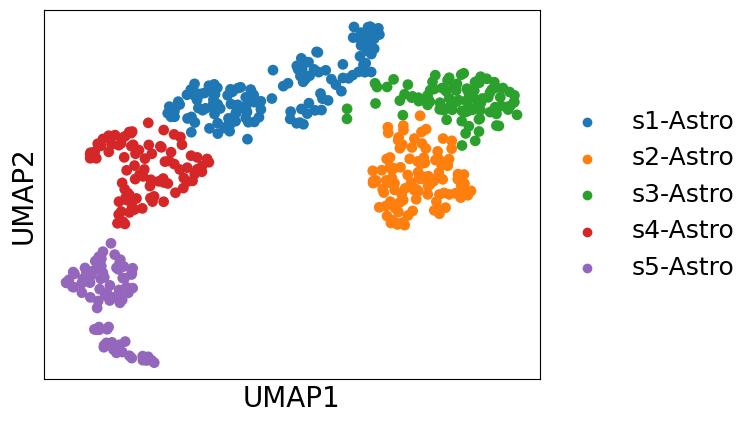

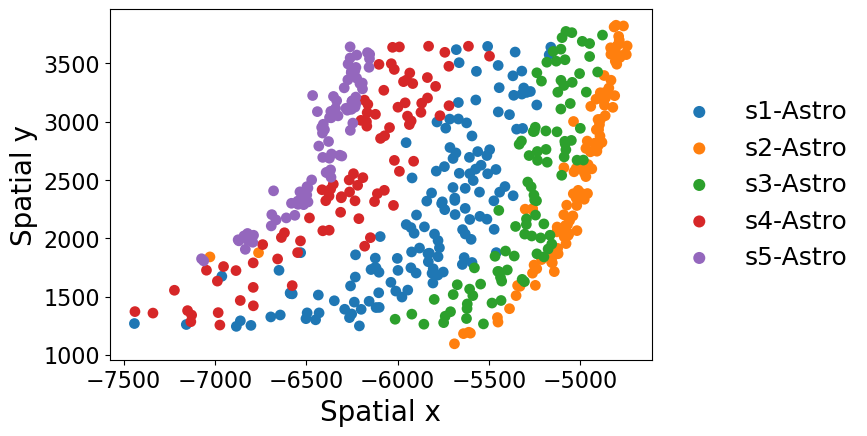

18      s4-Astro
19      s3-Astro
41      s1-Astro
70      s2-Astro
75      s1-Astro
          ...   
6050    s1-Astro
6053    s2-Astro
6065    s4-Astro
6119    s3-Astro
6131    s1-Astro
Name: leiden1, Length: 502, dtype: object
AnnData object with n_obs × n_vars = 3815 × 6096
    obs: 'cell_type', 'Spatial x', 'Spatial y', 'n_genes', 'leiden1', 'alpha'
    obsm: 'y'


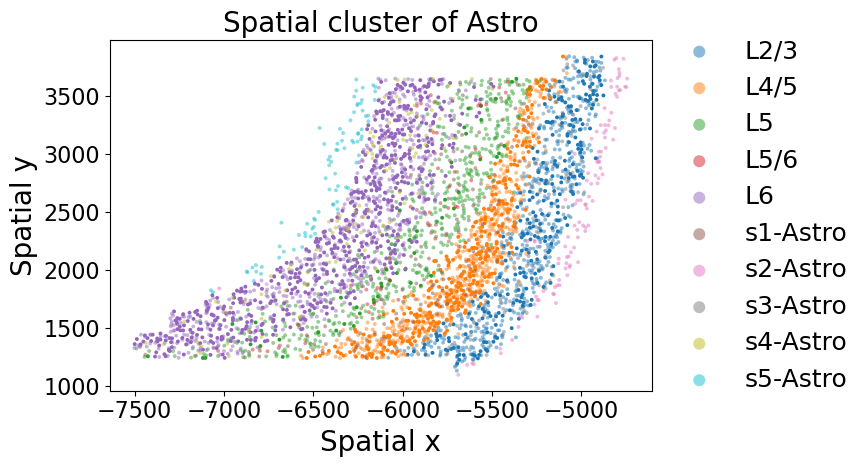

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


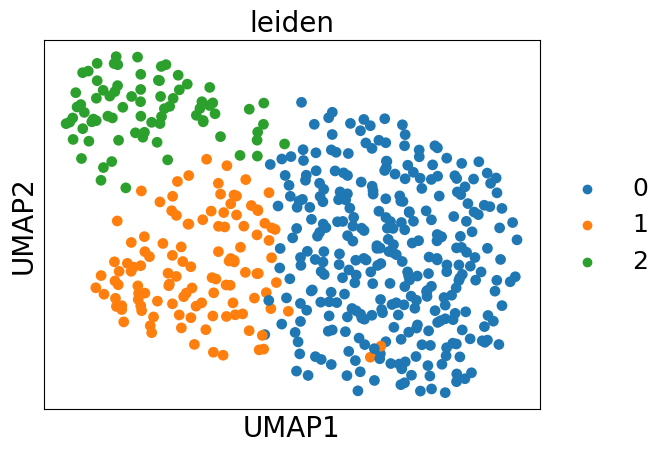

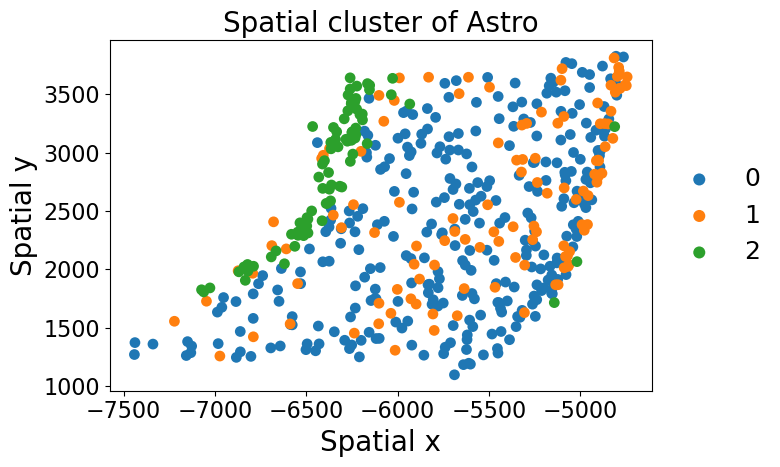

AnnData object with n_obs × n_vars = 502 × 6096
    obs: 'cell_type', 'Spatial x', 'Spatial y', 'n_genes', 'leiden', 'leiden1', 'alpha'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'leiden1_colors'
    obsm: 'y', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [18]:
COI="Astro"#"L2/3 IT"

def plot(adata1,type_to_plot="Astrocyte"):
    adata=adata1[adata1.obs["cell_type"]==type_to_plot]
    
    sc.tl.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)  # Compute the neighborhood graph
    
    # Clustering
    sc.tl.leiden(adata,resolution=0.2)  # or sc.tl.louvain(adata)
    
    # Plot UMAP
    sc.tl.umap(adata)  # Compute UMAP

    adata.obs["leiden"]=["s"+str(int(i)+1)+"-"+COI for i in adata.obs["leiden"].values]
    
    sc.pl.umap(adata, color='leiden',title="",save=COI.replace("/","-")+"-umap.pdf")
    
    sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title="",
        save=COI.replace("/","-")+"-sp.pdf"
    )

    adata.obs['leiden1']=[x for x in adata.obs['leiden']]
    adata.obs["alpha"]=[True for i in range(adata.shape[0])]

    adata_plot=sc.concat([adata,adata_neuron],axis=0)
    print(adata_plot.obs["leiden1"][adata_plot.obs['alpha']])
    print(adata_plot)
    sc.pl.scatter(
        adata_plot,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden1",
        title=f"Spatial cluster of {type_to_plot}",
        alpha=[0.5 if x else 1 for x in adata_plot.obs['alpha']]
    )

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot adata with full opacity
    sc.pl.scatter(
        adata,
        x='Spatial x',
        y='Spatial y',
        color='leiden1',
        ax=ax,
        alpha=1,
        show=False,
        title=f"Spatial cluster of {type_to_plot}"
    )

    # Plot adata_neuron with reduced opacity
    sc.pl.scatter(
        adata_neuron,
        x='Spatial x',
        y='Spatial y',
        color='leiden1',
        ax=ax,
        alpha=0.5,
        show=False,
        title=f"Spatial cluster of {type_to_plot}",
        save=COI.replace("/","-")+"-sup2.pdf"
    )

    adata_y_type=ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs)
    sc.tl.pca(adata_y_type, n_comps=50)
    sc.pp.neighbors(adata_y_type)  # Compute the neighborhood graph
    sc.tl.leiden(adata_y_type,resolution=0.5)  # or sc.tl.louvain(adata)
    sc.tl.umap(adata_y_type)  # Compute UMAP
    sc.pl.umap(adata_y_type, color='leiden')
    sc.pl.scatter(
        adata_y_type,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title=f"Spatial cluster of {type_to_plot}"
    )
    
    print(adata)
    return adata


adata_type=plot(adata,type_to_plot=COI)

# resolution: Astro 0.2, L2/3 IT 0.07

In [19]:
def extract_genes_and_pvals_by_group(adata, group_index, cutoff=0.05, up=True, name=None):
    # Extracting gene names and p-values from the adata object
    gene_names = adata.uns['rank_genes_groups']['names']
    p_values = adata.uns['rank_genes_groups']['pvals']
    logfoldchanges=adata.uns['rank_genes_groups']['logfoldchanges']
    p_adj=adata.uns['rank_genes_groups']['pvals_adj']
    
    # Lists to hold filtered gene names and their corresponding p-values
    filtered_genes = []
    filtered_pvals = []
    
    # Iterate through each group in the gene names and p-values
    for gene_group, pval_group,fold_group in zip(gene_names, p_adj, logfoldchanges):
        gene = gene_group[group_index]
        pval = pval_group[group_index]
        foldchange=fold_group[group_index]
        
        # Check if p-value is below the cutoff and add to the lists if it is
        #print(pval,foldchange)
        if pval < cutoff and ((foldchange>0)==up):
            filtered_genes.append(gene)
            filtered_pvals.append(pval)
    
    return filtered_genes, filtered_pvals

         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


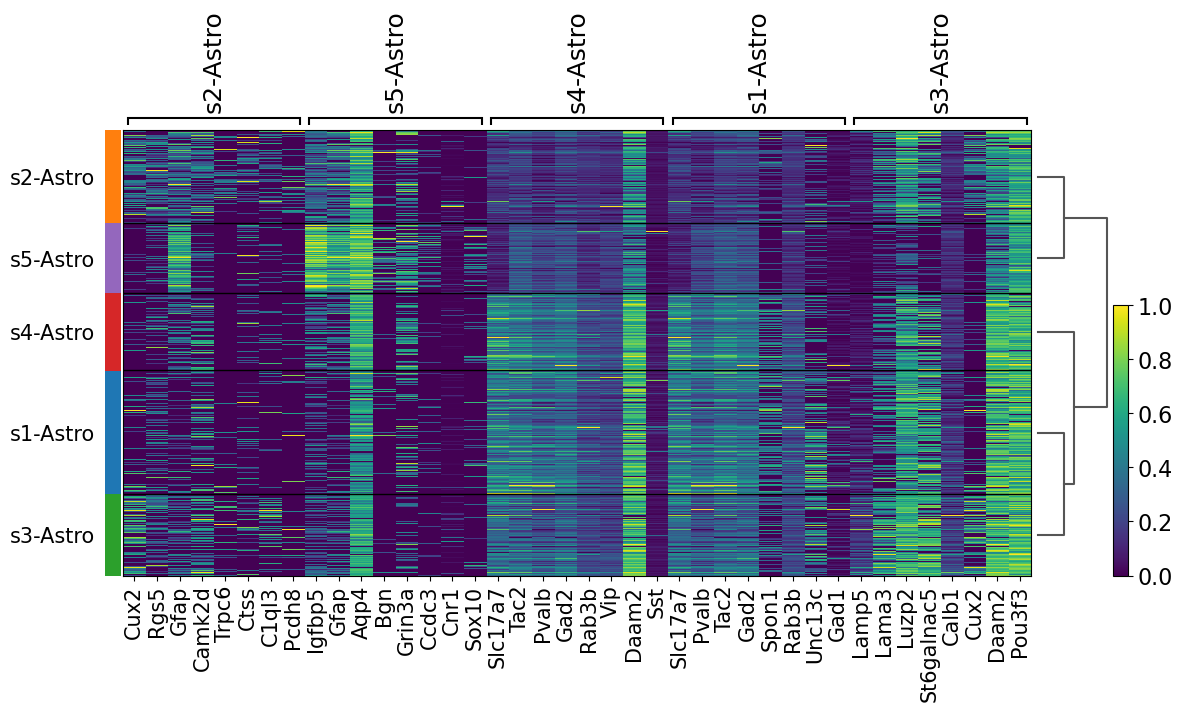

(['Cux2', 'Rgs5', 'Gfap', 'Camk2d', 'Trpc6', 'Ctss', 'C1ql3'], [3.569649699076269e-06, 0.00010471486132721845, 0.004277850884299594, 0.020691811106348684, 0.03178075759165199, 0.03625855685568333, 0.04011182198781811])
(['Cdh20', 'Pdlim5', 'Egfr', 'Wnt7b', 'Ramp1', 'Calb1', 'Daam2', 'Rab3b', 'Penk', 'Vip', 'Slc17a7', 'Gad2', 'Tac2', 'Pvalb'], [0.02824623479567781, 0.014764150784467616, 0.013524578499832667, 0.012219001504877506, 0.005486350425649584, 6.472306005963695e-06, 1.1003537539447377e-06, 4.3402730440146606e-09, 1.4949025198254636e-09, 1.4328603063672536e-16, 4.34959582366647e-17, 9.449202407562781e-19, 1.4827002361945644e-27, 1.4827002361945644e-27])


In [20]:
select=8
adata_y=ad.AnnData(X=np.abs(adata_type.obsm["y"]), obs=adata_type.obs)
#adata_y=adata_y[adata_y.obs['leiden'].isin(["0","1"])]#,"2","2","3"
adata_y.var_names=genes
sc.tl.rank_genes_groups(adata_y, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
# Generate the heatmap without displaying it immediately
sc.pl.rank_genes_groups_heatmap(adata_y, 
                                n_genes=select, 
                                show_gene_labels=True, 
                                standard_scale='var', 
                                cmap='viridis', 
                                show=False)

# Access all axes in the current figure
axes = plt.gcf().get_axes()

# Loop through each axis and remove the y-axis label
for ax in axes:
    ax.set_ylabel('')
plt.savefig("./figures/"+COI.replace("/","-")+"-DE.pdf", bbox_inches='tight')
# Show the plot
plt.show()

print(extract_genes_and_pvals_by_group(adata_y,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_y,1,0.05,False))

In [21]:
def print_adjusted_pvals(adata, n_genes=7):
    # Perform differential expression analysis
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    
    # Extract the results from rank_genes_groups
    results = adata.uns['rank_genes_groups']
    
    # Get the groups
    groups = results['names'].dtype.names
    
    # Iterate through each group and get the top n_genes
    for group in groups:
        print(f"Group {group}:")
        
        # Get the top n_genes and their corresponding adjusted p-values
        gene_names = results['names'][group][:n_genes]
        pvals_adj = results['pvals_adj'][group][:n_genes]
        
        # Print the results
        for gene, pval_adj in zip(gene_names, pvals_adj):
            print(f"Gene: {gene}, Adjusted p-value: {pval_adj}")
        print()

print_adjusted_pvals(adata_y)

Group s1-Astro:
Gene: Slc17a7, Adjusted p-value: 2.8138647949696894e-14
Gene: Pvalb, Adjusted p-value: 3.75982539315763e-10
Gene: Tac2, Adjusted p-value: 5.3252382596342914e-08
Gene: Gad2, Adjusted p-value: 8.339101366596784e-07
Gene: Spon1, Adjusted p-value: 5.165859811370131e-06
Gene: Rab3b, Adjusted p-value: 5.642315255656198e-06
Gene: Unc13c, Adjusted p-value: 5.746532466487658e-06

Group s2-Astro:
Gene: Cux2, Adjusted p-value: 3.569649699076269e-06
Gene: Rgs5, Adjusted p-value: 0.00010471486132721845
Gene: Gfap, Adjusted p-value: 0.004277850884299594
Gene: Camk2d, Adjusted p-value: 0.020691811106348684
Gene: Trpc6, Adjusted p-value: 0.03178075759165199
Gene: Ctss, Adjusted p-value: 0.03625855685568333
Gene: C1ql3, Adjusted p-value: 0.04011182198781811

Group s3-Astro:
Gene: Lamp5, Adjusted p-value: 7.896172687278607e-23
Gene: Lama3, Adjusted p-value: 8.498167493945027e-13
Gene: Luzp2, Adjusted p-value: 1.0886257132995706e-09
Gene: St6galnac5, Adjusted p-value: 3.6067981575403868e-

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


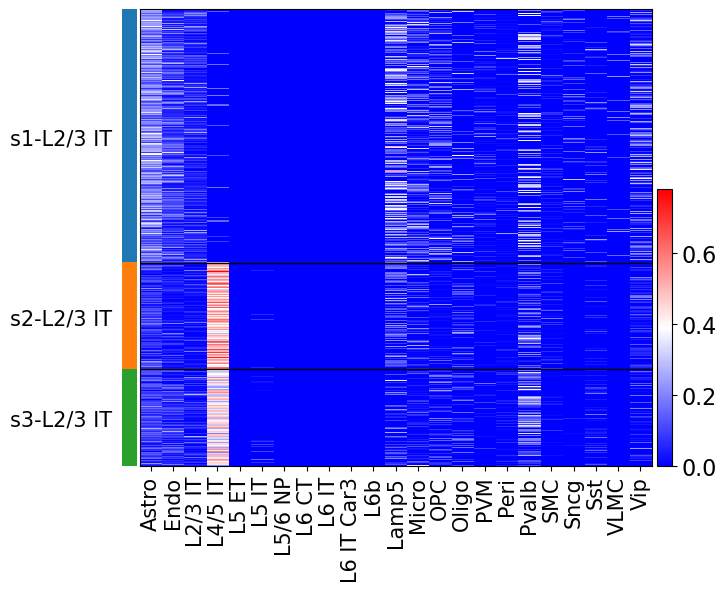

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


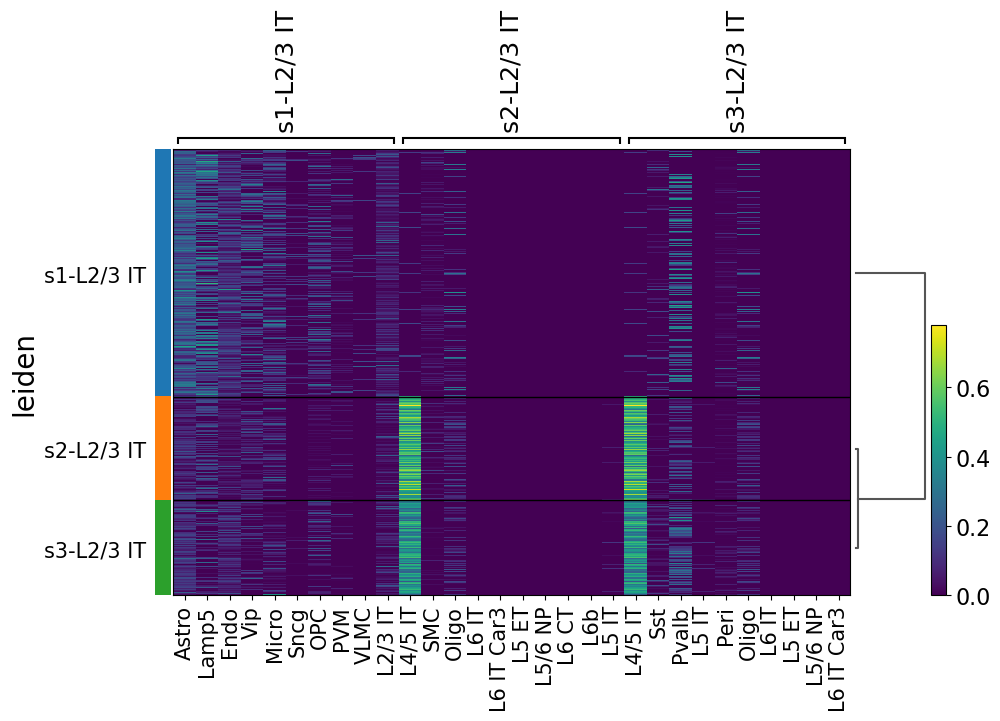

NameError: name 'extract_genes_and_pvals_by_group' is not defined

In [18]:
def aggregate_all_genes(adata):
    x=np.zeros((adata.shape[0],len(cell_types)))
    for i in range(len(cell_types)):
        offset=i*len(genes)
        x[:,i]=np.mean(np.abs(adata.X[:,offset:offset+len(genes)]),axis=1)
    #c=adata.shape[1]//len(genes)
    #x=x/c
    adata1=ad.AnnData(X=x, obs=adata.obs)
    adata1.var_names=cell_types
    return adata1[:,:-1]

adata_aggregated=aggregate_all_genes(adata_type)

sc.pl.heatmap(adata_aggregated, var_names=adata_aggregated.var_names, groupby='leiden', cmap='bwr',show=False)
# Get the current axis
ax = plt.gca()
# Remove the y-axis label
ax.set_ylabel('')
# Show the plot
# Save the modified plot with tight bounding box
fig.savefig("./figures/"+COI.replace("/","-")+"-heat.pdf", bbox_inches='tight')
plt.show()

sc.tl.rank_genes_groups(adata_aggregated, 'leiden', method='t-test')
sc.pl.rank_genes_groups_heatmap(adata_aggregated, n_genes=10, show_gene_labels=True, cmap='viridis')

print(extract_genes_and_pvals_by_group(adata_aggregated,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_aggregated,1,0.05,False))